In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [9]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [15]:
len(cifar2), len(cifar2_val)

(10000, 2000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


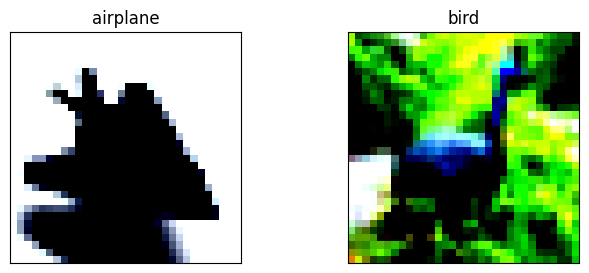

In [19]:
class_names = ['airplane','bird']
fig = plt.figure(figsize=(8,3))
for i in range(len(class_names)):
    ax = fig.add_subplot(1, 2, i+1, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next( img for img, label in cifar2 if label==i )
    plt.imshow(img.permute(1,2,0))

In [5]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [11]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

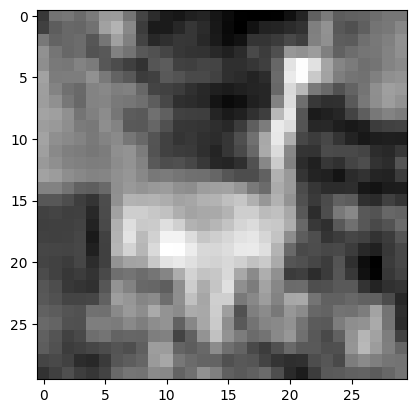

In [12]:
plt.imshow(output[0,0].detach(), cmap='gray')

In [20]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [21]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

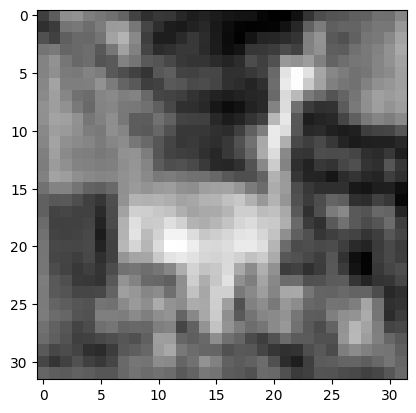

In [22]:
plt.imshow(output[0,0].detach(), cmap='gray')

In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    #
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [24]:
numel_list = [p.numel() for p in model.parameters() ]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [25]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [37]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # [8,8,8] flatten to [512]
    nn.Flatten(),
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [38]:
numel_list = [p.numel() for p in model.parameters() ]
output = model(img.unsqueeze(0))
output.shape, sum(numel_list), numel_list

(torch.Size([1, 2]), 18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

自定义module

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [40]:
model = Net()
numel_list = [p.numel() for p in model.parameters() ]
output = model(img.unsqueeze(0))
output.shape, sum(numel_list), numel_list

(torch.Size([1, 2]), 18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

函数式api

In [41]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [43]:
model = Net()
numel_list = [p.numel() for p in model.parameters() ]
output = model(img.unsqueeze(0))
output, output.shape, sum(numel_list), numel_list

(tensor([[ 0.1370, -0.1191]], grad_fn=<AddmmBackward0>),
 torch.Size([1, 2]),
 18090,
 [432, 16, 1152, 8, 16384, 32, 64, 2])

In [49]:
import datetime
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader))) 

In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, 
              model=model,loss_fn=loss_fn, train_loader=train_loader)

2024-01-22 11:39:18.581270 Epoch 1, Training loss 0.5945577896704339
2024-01-22 11:39:39.465142 Epoch 10, Training loss 0.33852658786211803
2024-01-22 11:40:02.541009 Epoch 20, Training loss 0.297583275444948
2024-01-22 11:40:25.346183 Epoch 30, Training loss 0.27068785801055323
2024-01-22 11:40:48.780256 Epoch 40, Training loss 0.2503228293625033
2024-01-22 11:41:11.831141 Epoch 50, Training loss 0.23138005158324151
2024-01-22 11:41:34.476791 Epoch 60, Training loss 0.21769270680512592
2024-01-22 11:41:58.312307 Epoch 70, Training loss 0.20072568924563705
2024-01-22 11:42:20.976802 Epoch 80, Training loss 0.1871939763236957
2024-01-22 11:42:43.845687 Epoch 90, Training loss 0.17343726597583978
2024-01-22 11:43:07.708563 Epoch 100, Training loss 0.16058986368262843


In [ ]:
def val_accuracy(model, val_data):
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    return correct, total, correct/total